## Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import time

from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [17]:
# Load Data and Labels
X = pd.read_csv('/kaggle/input/secomdata/secom.data', sep=' ', header=None)
y = pd.read_csv('/kaggle/input/secomdata/secom_labels.data', sep=' ', header=None)[0]
print("X shape:", X.shape)
print("y shape:", y.shape)

# Zero-variance
variance = VarianceThreshold(threshold=0.0)
X_variance = variance.fit_transform(X)
print("Non zero-variance features:", X_variance.shape)

# Drop NaNs
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_variance)
print("Number of NaNs:", np.isnan(X_imputed).sum())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("Mean:", X_scaled.mean(axis=0)[:10])
print("Std:", X_scaled.std(axis=0)[:10])

X shape: (1567, 590)
y shape: (1567,)
Non zero-variance features: (1567, 474)
Number of NaNs: 0
Mean: [ 1.62332035e-15 -5.07372631e-15 -5.71336214e-15 -1.26963603e-16
  0.00000000e+00 -2.90202521e-16  1.14720684e-15 -5.44129727e-17
  0.00000000e+00 -9.06882879e-18]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Select Top 20 Features

In [18]:
# Filter
start = time.perf_counter()
mutual_info = mutual_info_classif(X_scaled, y, random_state=42)

# Top 20 Features
top_features = np.argsort(mutual_info)[-20:][::-1]
X_mi_features = X_scaled[:, top_features]

end = time.perf_counter()

print("Mutual Information features shape:", X_mi_features.shape)
print("Mutual Information Time:", end - start)


Mutual Information features shape: (1567, 20)
Mutual Information Time: 2.890428753999913


In [19]:
# RFE
rf = RandomForestClassifier(
    n_estimators=30,
    random_state=42,
    n_jobs=-1
)
# Top 20 Features
rfe = RFE(
    estimator=rf,
    n_features_to_select=20,
    step=10
)

start = time.perf_counter()
rfe.fit(X_scaled, y)
X_rfe_features = rfe.transform(X_scaled)
end = time.perf_counter()

print("RFE features shape:", X_rfe_features.shape)
print("RFE time:", end - start)


RFE features shape: (1567, 20)
RFE time: 19.548592165999935


In [20]:
# SVD decomposition
U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)
k = 20  # Number of principal components
scores = np.zeros(Vt.shape[1])

start = time.perf_counter()
for j in range(Vt.shape[1]):
    for i in range(k):
        scores[j] = scores[j] + (S[i]**2) * abs(Vt[i, j])

top_svd_features = np.argsort(scores)[-20:][::-1]
X_svd_features = X_scaled[:, top_svd_features]
end = time.perf_counter()

print("SVD features shape:", X_svd_features.shape)
print("SVD time:", end - start)

SVD features shape: (1567, 20)
SVD time: 0.016069699000127002


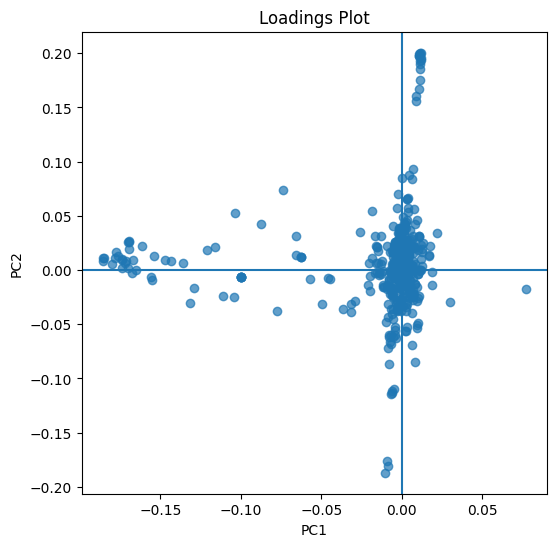

In [21]:
pc1 = Vt[0, :]
pc2 = Vt[1, :]

plt.figure(figsize=(6, 6))
plt.scatter(pc1, pc2, alpha=0.7)
plt.axhline(0)
plt.axvline(0)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Loadings Plot")
plt.savefig("loadings_plot.pdf")
plt.show()


## Noisy Data

In [22]:
noise = 0.05
noise = noise * np.std(X_scaled) * np.random.randn(*X_scaled.shape)
X_noisy = X_scaled + noise

In [23]:
# SVD
U_n, S_n, Vt_n = np.linalg.svd(X_noisy, full_matrices=False)

k = 20
scores_noisy = np.zeros(Vt_n.shape[1])

for j in range(Vt_n.shape[1]):
    for i in range(k):
        scores_noisy[j] = scores_noisy[j] + (S_n[i]**2) * abs(Vt_n[i, j])

top_svd_noisy = set(np.argsort(scores_noisy)[-20:])
top_svd_clean = set(top_svd_features)

# RFE
rfe.fit(X_scaled, y)
top_rfe_clean = set(np.where(rfe.support_)[0])

# RFE noisy
rfe.fit(X_noisy, y)
top_rfe_noisy = set(np.where(rfe.support_)[0])


## Stability

In [24]:
# Stability
svd_stability = len(top_svd_clean & top_svd_noisy)
rfe_stability = len(top_rfe_clean & top_rfe_noisy)

print("SVD stability:", svd_stability)
print("RFE stability:", rfe_stability)


SVD stability: 20
RFE stability: 10


## Logistic Regression

In [25]:
# Models
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    return accuracy_score(y_test, ypred), f1_score(y_test, ypred)

results = []

# Mutual Information
start = time.perf_counter()
acc, f1 = evaluate_model(X_mi_features, y)
mi_time = time.perf_counter() - start
results.append(["MI", mi_time, acc, f1])

# RFE
start = time.perf_counter()
acc, f1 = evaluate_model(X_rfe_features, y)
rfe_time = time.perf_counter() - start
results.append(["RFE", rfe_time, acc, f1])

# SVD
start = time.perf_counter()
acc, f1 = evaluate_model(X_svd_features, y)
svd_time = time.perf_counter() - start
results.append(["SVD", svd_time, acc, f1])

df_results = pd.DataFrame(
    results,
    columns=["Method", "Feature Selection Time (s)", "Accuracy", "F1-score"]
)

print(df_results)

  Method  Feature Selection Time (s)  Accuracy  F1-score
0     MI                    0.013674  0.929936  0.000000
1    RFE                    0.011088  0.940552  0.222222
2    SVD                    0.013471  0.936306  0.062500


## Venn Diagram

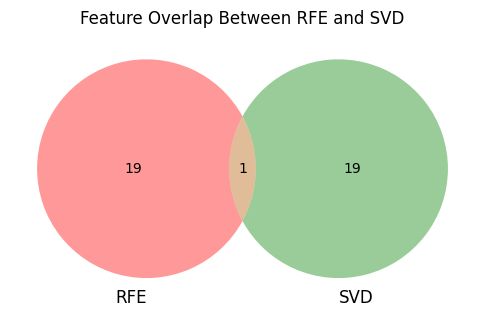

In [26]:
set_rfe = set(np.where(rfe.support_)[0])
set_svd = set(top_svd_features)

plt.figure(figsize=(6, 6))
venn2([set_rfe, set_svd], set_labels=('RFE', 'SVD'))
plt.title('Feature Overlap Between RFE and SVD')
plt.savefig('overlap.pdf')
plt.show()
